In [31]:
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi

from qutip import *
from qutip.control import *
from qutip.qip.operations import rx
from qutip.qip.operations import ry
from qutip.qip.operations import rz

from qutip.control.grape import plot_grape_control_fields, _overlap
from qutip.control.cy_grape import cy_overlap
from qutip.control.grape import cy_grape_unitary, grape_unitary_adaptive

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
from dataclasses import dataclass
from typing import List, Tuple, Sequence

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
import plotly.express as px

from scipy.constants import physical_constants, h

from qutip import jmat, tensor, identity, Qobj

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_bloch_multivector

# Finding Pulse Sequence

### Setting beginning and ending states
### setting desired U value

In [32]:
qubit1state=basis(3, 0)
qubit2state=basis(3, 0)
startingstate=tensor(qubit1state,qubit1state) #initial state
#endingstate= tensor(basis(3,0),basis(3,2))
startingstate.dims=[[9],[1]]
#endingstate.dims=[[9],[1]]
print (startingstate)





U=tensor(rotation(jmat(1,'x'),pi/2),identity(3))
U.dims=[[9],[9]]
U

#rotation in x about 

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


C:\Users\RA\AppData\Local\Temp\ipykernel_2544\3398385443.py:13: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  U=tensor(rotation(jmat(1,'x'),pi/2),identity(3))


Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 0.85355339+0.j   0.        +0.j   0.        +0.j   0.        -0.5j
   0.        +0.j   0.        +0.j  -0.14644661+0.j   0.        +0.j
   0.        +0.j ]
 [ 0.        +0.j   0.85355339+0.j   0.        +0.j   0.        +0.j
   0.        -0.5j  0.        +0.j   0.        +0.j  -0.14644661+0.j
   0.        +0.j ]
 [ 0.        +0.j   0.        +0.j   0.85355339+0.j   0.        +0.j
   0.        +0.j   0.        -0.5j  0.        +0.j   0.        +0.j
  -0.14644661+0.j ]
 [ 0.        -0.5j  0.        +0.j   0.        +0.j   0.70710678+0.j
   0.        +0.j   0.        +0.j   0.        -0.5j  0.        +0.j
   0.        +0.j ]
 [ 0.        +0.j   0.        -0.5j  0.        +0.j   0.        +0.j
   0.70710678+0.j   0.        +0.j   0.        +0.j   0.        -0.5j
   0.        +0.j ]
 [ 0.        +0.j   0.        +0.j   0.        -0.5j  0.        +0.j
   0.        +0.j   0.70710678+0.j   0.        +

## Defining 3x3 pauli spin matrices 
## Definiting number of iterations
## Defining H_ops

In [33]:

R = 150 #GRAPE itterations

T = 1
times = np.linspace(0, T, 100)


#wirting our terms so I can actually read the hamiltonian
#Nuc terms are second qubit
#Elec qubit is first qubit

nuclear_spin = 1
electron_spin = 1
sigmaxE = jmat(electron_spin,'x')
sigmayE = jmat(electron_spin,'y')
#print (sigmayE)
sigmazE = jmat(electron_spin,'z')
sigmaxN = jmat(nuclear_spin,'x')
sigmayN = jmat(nuclear_spin,'y')
sigmazN = jmat(nuclear_spin,'z')
sigmazEsquared = sigmazE*sigmazE
sigmazNsquared = sigmazN*sigmazN
identity3 = identity(3) #3x3 identity matrix

# RF field can only control Sx and Sy for both qubits
#Creating operators that can be tuned in the Hamiltonian via the control fields, list is below called H_ops

H_opsEx=tensor(sigmaxE, identity3)
H_opsEy=tensor(sigmayE, identity3)
H_opsEz=tensor(sigmazE, identity3)



H_opsNx=tensor(identity3, sigmaxN)
H_opsNy=tensor(identity3, sigmayN)
H_opsNz=tensor(identity3, sigmazN)

H_opsENx = tensor(sigmaxE, sigmaxN)
H_opsENy = tensor(sigmayE, sigmayN)           
H_opsENz = tensor(sigmazE, sigmazN)
#print (H_opsENz)

#changing dims bc qutip is silly

H_opsEx.dims=[[9],[9]]
H_opsEy.dims=[[9],[9]]
H_opsEz.dims=[[9],[9]]

H_opsNx.dims=[[9],[9]]
H_opsNy.dims=[[9],[9]]
H_opsNz.dims=[[9],[9]]

H_opsENx.dims=[[9],[9]]
H_opsENy.dims=[[9],[9]]
H_opsENz.dims=[[9],[9]] 


#making H_ops list           
H_ops = [H_opsEx, H_opsEy, H_opsEz, H_opsNx, H_opsNy, H_opsNz]   #, H_opsENx, H_opsENy, H_opsENz]            
               
               
#making labels for pulse sequence graphs
H_labels = [r'$uE_{x}$',
            r'$uE_{y}$',
            r'$uE_{z}$',
            r'$uN_{x}$',
            r'$uN_{y}$',
            r'$uN_{z}$',
            r'$uEN_{x}$',
            r'$uEN_{y}$',
            r'$uEN_{z}$']


# Defining hamiltonian and constants 

In [27]:
#defining hamiltonian for NV center


#witing out hamiltonian terms


H1 = tensor(pi*jmat(1,'z'), identity(3))
print (H1)
H2= tensor(identity(3), pi*jmat(1,'z'))
print (H2)
H0= H1+H2

H0.dims=[[9],[9]]
H0 #hamiltonian without b field term



Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 3.14159265  0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          3.14159265  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          3.14159265  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -3.14159265  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         -3.14159265  0.        ]
 [ 0.          0.          0.          0.          0.          0

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 6.28318531  0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          3.14159265  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          3.14159265  0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -3.14159265
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         -3.14159265  0.        ]
 [ 0.          0.          0.          0.          0.         

# Plot pulses

In [28]:
##creating initial control pulse values as starting guess for GRAPE

u0 = np.array([np.random.rand(len(times)) * 2 * pi * 0.005 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10) / 10, u0[idx, :], mode='same') for idx in range(len(H_ops))]


In [21]:
#doing GRAPE!

result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, eps=2 * pi / T, phase_sensitive=False,
                          progress_bar=TextProgressBar())



10.0%. Run time:   8.72s. Est. time left: 00:00:01:18
20.0%. Run time:  16.59s. Est. time left: 00:00:01:06
30.0%. Run time:  25.52s. Est. time left: 00:00:00:59
40.0%. Run time:  34.16s. Est. time left: 00:00:00:51
50.0%. Run time:  41.97s. Est. time left: 00:00:00:41
60.0%. Run time:  49.75s. Est. time left: 00:00:00:33
70.0%. Run time:  57.54s. Est. time left: 00:00:00:24
80.0%. Run time:  65.33s. Est. time left: 00:00:00:16
90.0%. Run time:  73.83s. Est. time left: 00:00:00:08
Total run time:  81.23s


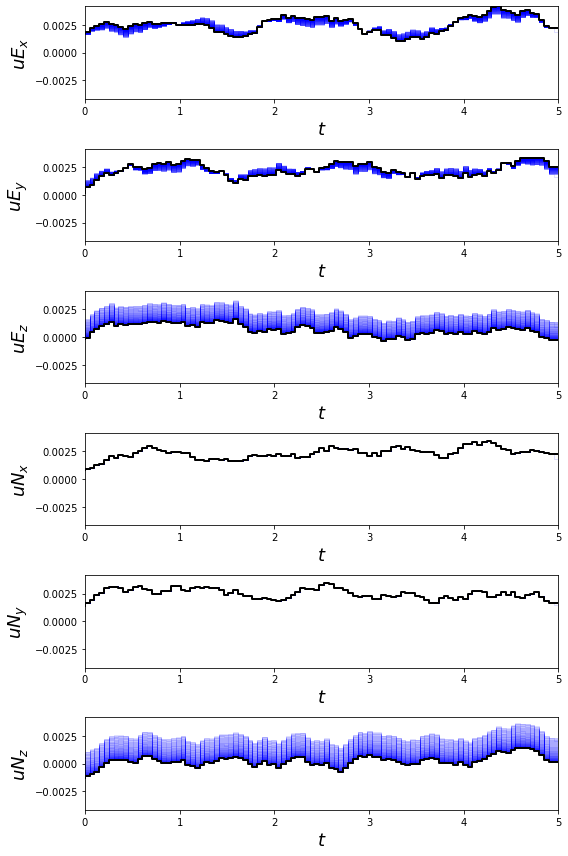

In [22]:
plot_grape_control_fields(times, result.u[:, :, :] / (2 * pi), H_labels, uniform_axes=True);
plt.show()

# Calcuate fidelity

In [13]:
idealfinalstate=U*startingstate
print (idealfinalstate)

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[ 0.85355339+0.j ]
 [ 0.        +0.j ]
 [ 0.        +0.j ]
 [ 0.        -0.5j]
 [ 0.        +0.j ]
 [ 0.        +0.j ]
 [-0.14644661+0.j ]
 [ 0.        +0.j ]
 [ 0.        +0.j ]]


In [14]:
result.U_f.tidyup(1e-2)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 0.99961154-0.02336486j  0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j         -0.99975234+0.01262196j  0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.99988281+0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.99976398+0.01074315j  0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0

In [15]:
realfinalstate=result.U_f*startingstate
print (realfinalstate)

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[0.99961154-0.02336486j]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]]


In [40]:
idealdensitymatrix=(idealfinalstate * idealfinalstate.dag())#ideal density matrix
densitymatrix=(realfinalstate * realfinalstate.dag())# real density matrix
print (idealdensitymatrix)
print (densitymatrix)
fidelity(idealdensitymatrix,densitymatrix)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 0.72855339+0.j         0.        +0.j         0.        +0.j
   0.        +0.4267767j  0.        +0.j         0.        +0.j
  -0.125     +0.j         0.        +0.j         0.        +0.j       ]
 [ 0.        +0.j         0.        +0.j         0.        +0.j
   0.        +0.j         0.        +0.j         0.        +0.j
   0.        +0.j         0.        +0.j         0.        +0.j       ]
 [ 0.        +0.j         0.        +0.j         0.        +0.j
   0.        +0.j         0.        +0.j         0.        +0.j
   0.        +0.j         0.        +0.j         0.        +0.j       ]
 [ 0.        -0.4267767j  0.        +0.j         0.        +0.j
   0.25      +0.j         0.        +0.j         0.        +0.j
   0.        +0.0732233j  0.        +0.j         0.        +0.j       ]
 [ 0.        +0.j         0.        +0.j         0.        +0.j
   0.        +0.j         0.        +0.j      

0.8873337413860005

# Plotting City Scape


In [38]:
#plotting cityscape for real density matrix
dm=np.array(densitymatrix)
print (dm)
plot_state_city(dm, title='State Tomography for Real State')

[[0.99999992+0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j]
 [0.  

VisualizationError: 'Input is not a multi-qubit quantum state.'

In [39]:
#plotting cityscape for ideal density matrix
idm=np.array(idealdensitymatrix)
print (idm)
plot_state_city(idm, title='State Tomography for Ideal State')

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


VisualizationError: 'Input is not a multi-qubit quantum state.'